It is worth noting that the disba program was used here to synthesize the dispersion data, while the actual observations were manually picked up from the dispersion energy map

In [1]:
import sys
sys.path.append("..")
sys.path.append("../ADsurf")
sys.path.append("../ADsurf/_cps")
from ADsurf._ADsurf import *

data_path = "./data/00_increase_layer/"
model = Model()

## 1. Model parameter

In [3]:
dc = 0.001
vmin = 2
vmax = 3.2
tmin = 1/10
tmax = 5
layering_method = "LN"
initialize_method = "Brocher"
layering_ratio = 1.2
depth_factor=  3.8
layer_number = 6
vp_vs_ratio = 2.45
rho = 2
fundamental_range = []
model_parameter = Model_param(
            dc=dc,
            vmin=vmin,
            vmax=vmax,
            tmin=tmin,
            tmax=tmax,
            layering_method=layering_method,
            initialize_method=initialize_method,
            layering_ratio=layering_ratio,
            depth_factor=depth_factor,
            layer_number=layer_number,
            vp_vs_ratio=vp_vs_ratio,
            rho=rho,
            fundamental_range = fundamental_range
            )

## 2. velocity model

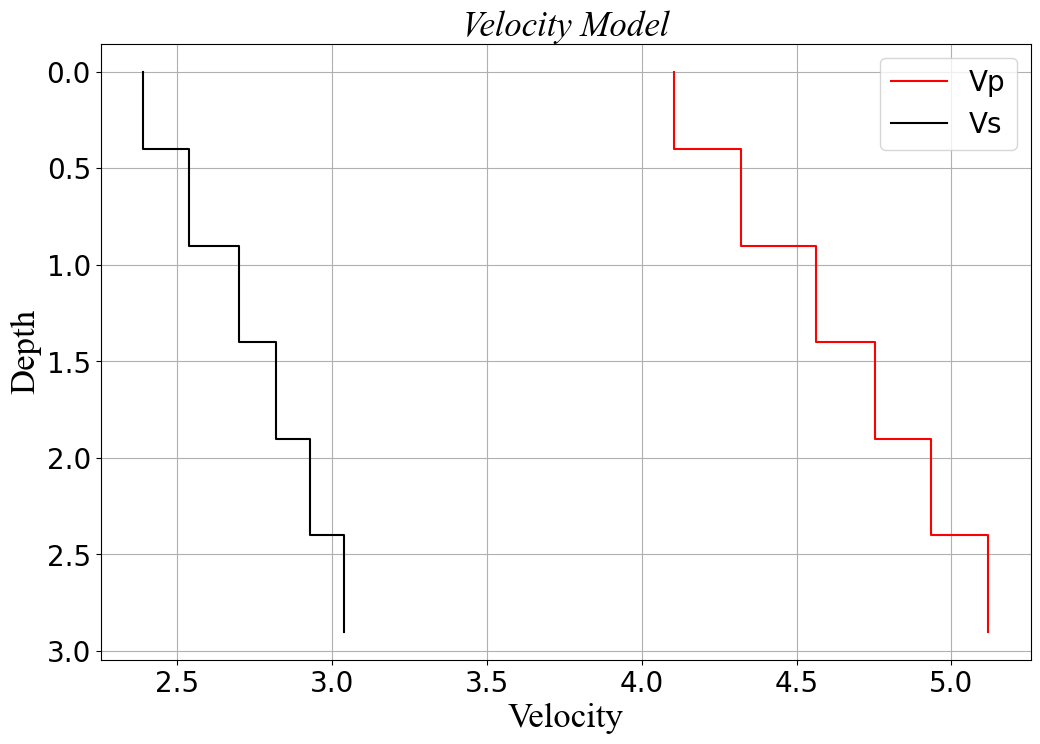

In [4]:
thick_true = np.array([0.4,0.5,0.5,0.5,0.5,0.5])
vs_true = np.array([2.39,2.54,2.7,2.82,2.93,3.04])
thick_true,vp_true,vs_true,rho_true = gen_model(thick_true,vs_true,area=True)
true_model = {
    "thick":thick_true.tolist(),
    "vp":vp_true.tolist(),
    "vs":vs_true.tolist(),
    "rho":rho_true.tolist(),
}
true_model = True_model(model_parameter,thick=true_model["thick"],vs=true_model["vs"],vp=true_model["vp"],rho=true_model["rho"])
model.true_model = true_model
plot_velModel(true_model.thick,true_model.vp,true_model.vs)

## 3.calculate the determinant of dispersion function

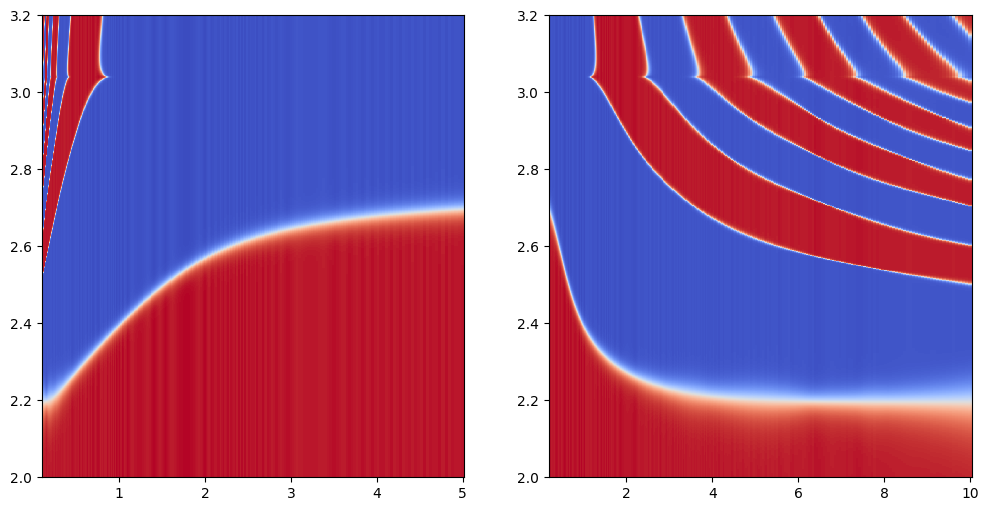

In [5]:
# calculate the determinant dipersion function
F = model.true_model._cal_determinant(sampling_method="log-wavelength",sampling_num=500)
# post process
disp_matrix_symbol = torch.sign(F.detach())
disp_matrix = F/(torch.max(F,dim=0).values - torch.min(F,dim=0).values)
disp_matrix_compress = (1e-31)**torch.abs(disp_matrix)-1
disp_matrix_compress = disp_matrix_compress/(torch.max(disp_matrix_compress,dim=0).values - torch.min(disp_matrix_compress,dim=0).values)
disp_matrix_compress = disp_matrix_compress*disp_matrix_symbol
disp_matrix_plot = disp_matrix_compress
disp_matrix_plot[disp_matrix_plot>0] = disp_matrix_plot[disp_matrix_plot>0]/disp_matrix_plot.max()
disp_matrix_plot[disp_matrix_plot<0] = disp_matrix_plot[disp_matrix_plot<0]/np.abs(disp_matrix_plot.min())
disp_matrix_plot = disp_matrix_plot.numpy()
tlist = tensor2numpy(model.true_model.tlist)
vlist = tensor2numpy(model.true_model.vlist)

plt.figure(figsize=(12,6))
T_list,V_list_T     = np.meshgrid(tlist,vlist)
Freq_list,V_list_F  = np.meshgrid(1/tlist,vlist)
cmap="coolwarm"
plt.subplot(121)
plt.pcolormesh(T_list,V_list_T,disp_matrix_plot,cmap=cmap)

plt.subplot(122)
plt.pcolormesh(Freq_list,V_list_F,disp_matrix_plot,cmap=cmap)
plt.show()

## 4.calculate the dispersion curve

In [6]:
pvs_obs = disp_obs = model.true_model._cal_dispersion_curve(sampling_method="log-wavelength",sampling_num=500,dispOrder=[0])

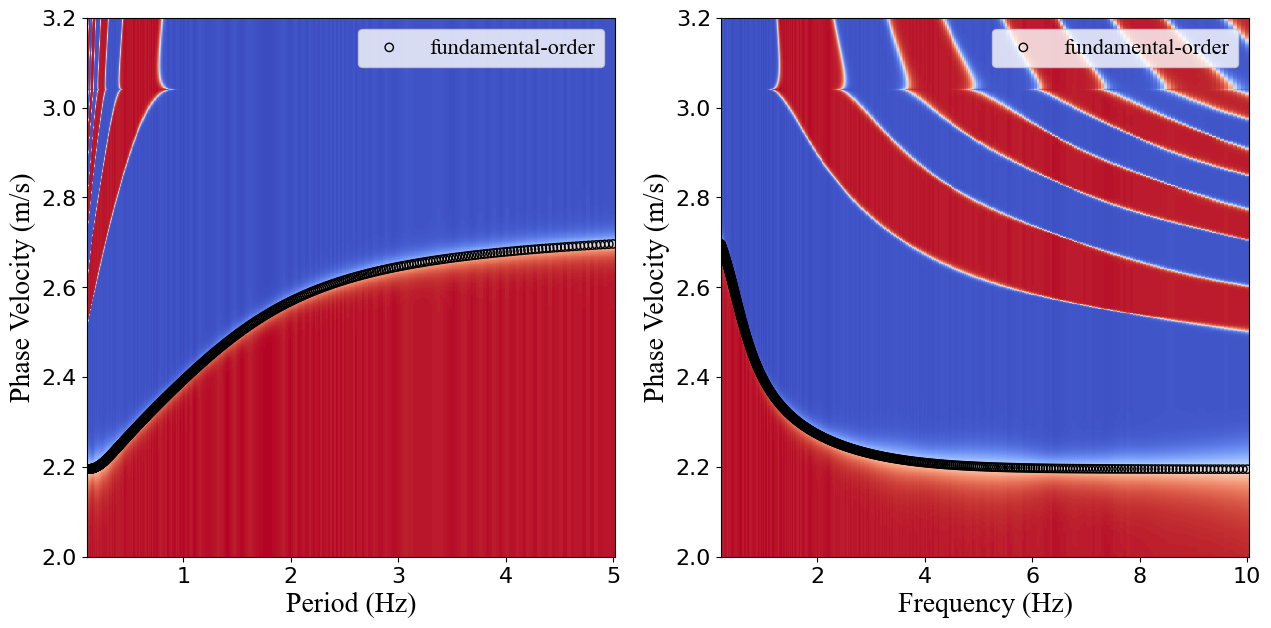

In [7]:
plot_param = {
    'label_font':{
                'fontsize':20,
                'color':'k',
                'family':'Times New Roman',
                'weight':'normal',
                # 'style':'italic',
                },
    'cbar_font':{
                'fontsize':16,
                'color':'k',
                'family':'Times New Roman',
                'weight':'normal',
                # 'style':'italic',
    },
    "legend_font":{
        'family': 'Times New Roman',  # 字体
        'style': 'normal',
        'size': 16,  # 字号
        'weight': "normal",  # 是否加粗，不加粗
    },
    'tick_fontsize':16,
}
plot_param = dictToObj(plot_param)

plt.figure(figsize=(15,7))
T_list,V_list_T     = np.meshgrid(tlist,vlist)
Freq_list,V_list_F  = np.meshgrid(1/tlist,vlist)
cmap="coolwarm"

plt.subplot(121)
plt.pcolormesh(T_list,V_list_T,disp_matrix_plot,cmap=cmap)
mask = pvs_obs[:,2]==0
plt.scatter(pvs_obs[:,0][mask],pvs_obs[:,1][mask],marker="o",edgecolors='black',facecolor="none",label="fundamental-order")
plt.ylim(vmin,vmax)
plt.xticks(fontsize=plot_param.tick_fontsize)
plt.yticks(fontsize=plot_param.tick_fontsize)
plt.xlabel("Period (Hz)",fontdict=plot_param.label_font)
plt.ylabel("Phase Velocity (m/s)",fontdict=plot_param.label_font)
plt.legend(loc='upper right',prop=plot_param.legend_font,frameon=True)

plt.subplot(122)
plt.pcolormesh(Freq_list,V_list_F,disp_matrix_plot,cmap=cmap)
mask = pvs_obs[:,2]==0
plt.scatter(1/pvs_obs[:,0][mask],pvs_obs[:,1][mask],marker="o",edgecolors='black',facecolor="none",label="fundamental-order")
plt.ylim(vmin,vmax)
plt.xticks(fontsize=plot_param.tick_fontsize)
plt.yticks(fontsize=plot_param.tick_fontsize)
plt.xlabel("Frequency (Hz)",fontdict=plot_param.label_font)
plt.ylabel("Phase Velocity (m/s)",fontdict=plot_param.label_font)
plt.legend(loc='upper right',prop=plot_param.legend_font,frameon=True)
plt.savefig(os.path.join(data_path,"input/observed_data.png"),bbox_inches='tight',dpi=300)
plt.show()

In [8]:
# save the dispersion curve
np.savetxt(os.path.join(data_path,"input/disper.txt"),pvs_obs)